In [15]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, TimeDistributed, Masking
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


In [16]:

def extract_mfcc(file_path, sr=22050, n_mfcc=13):
    
    y, sr = librosa.load(file_path, sr=sr)  
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)  #
    return mfcc.T  


# Example usage
file_path = r'D:\Edukation\Lectures\WiSe2024\SAA\Dataset\GTZAN\archive\Data\genres_original\blues\blues.00000.wav'
mfcc_features = extract_mfcc(file_path)


In [18]:
import os

data_dir = r"D:\Edukation\Lectures\WiSe2024\SAA\Dataset\GTZAN\archive\Data\genres_original"

if not os.path.exists(data_dir):
    raise FileNotFoundError(f"The directory {data_dir} does not exist. Please check the path.")

features = []
labels = []
genres = os.listdir(data_dir)

for genre_idx, genre in enumerate(genres):
    genre_path = os.path.join(data_dir, genre)
    for file_name in os.listdir(genre_path):
        file_path = os.path.join(genre_path, file_name)
        try:
            mfcc = extract_mfcc(file_path)  
            features.append(mfcc)
            labels.append(genre_idx)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

print(f"Number of samples: {len(features)}")
print(f"Shape of first sample: {features[0].shape if features else 'No features extracted'}")


Number of samples: 999
Shape of first sample: (1293, 13)


In [19]:
max_timesteps = max([f.shape[0] for f in features])
features_padded = [
    np.pad(f, ((0, max_timesteps - f.shape[0]), (0, 0)), mode="constant") for f in features
]
features_padded = np.array(features_padded)


#print(f"Raw labels shape: {np.array(labels).shape}")
#print(f"Raw labels: {labels[:10]}")  # Show the first 10 labels
#labels = np.array(labels).flatten()

# Convert labels to integers
#labels = np.array(labels).astype(int)
#print(f"Raw labels: {labels[:10]}") 

In [20]:

labels = np.array(labels).flatten()


num_classes = len(set(labels)) 
print(f"Number of unique classes: {num_classes}")


labels = labels.astype(int)  
print(f"Raw labels before one-hot encoding: {labels.shape}") 
labels = tf.keras.utils.to_categorical(labels, num_classes=num_classes)  

print(f"Shape of labels after one-hot encoding: {labels.shape}") 


X_train, X_test, y_train, y_test = train_test_split(features_padded, labels, test_size=0.2, random_state=42)


print(f"X_train shape: {X_train.shape}") 
print(f"y_train shape: {y_train.shape}") 


Number of unique classes: 10
Raw labels before one-hot encoding: (999,)
Shape of labels after one-hot encoding: (999, 10)
X_train shape: (799, 1320, 13)
y_train shape: (799, 10)


In [21]:


#labels = tf.keras.utils.to_categorical(labels)


#print(f"Shape of features_padded: {features_padded.shape}")  # (samples, timesteps, features)
#print(f"Shape of labels: {labels.shape}")  # (samples, num_classes)




#X_train, X_test, y_train, y_test = train_test_split(features_padded, labels, test_size=0.2, random_state=42)



In [29]:

def create_lstm_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    masked = Masking(mask_value=0.0)(input_layer)
    lstm = LSTM(128, return_sequences=True)(masked)
    lstm = LSTM(128)(lstm)
    dropout = Dropout(0.3)(lstm)
    output_layer = Dense(num_classes, activation="softmax")(dropout)
    return Model(inputs=input_layer, outputs=output_layer)

In [30]:

input_shape = X_train.shape[1:]  
model = create_lstm_model(input_shape, num_classes)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [31]:

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.1883 - loss: 2.2010 - val_accuracy: 0.2850 - val_loss: 1.8542
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.3983 - loss: 1.7294 - val_accuracy: 0.4700 - val_loss: 1.5817
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.4885 - loss: 1.5133 - val_accuracy: 0.4550 - val_loss: 1.5459
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.5410 - loss: 1.3075 - val_accuracy: 0.5100 - val_loss: 1.4472
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.6197 - loss: 1.1364 - val_accuracy: 0.4300 - val_loss: 1.5958
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5663 - loss: 1.2315 - val_accuracy: 0.3850 - val_loss: 1.7322
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.5279 - loss: 1.3061 - val_accuracy: 0.4750 - val_loss: 1.5084
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.6160 - loss: 1.1046 - val_accuracy: 0.4800 - val_loss:

In [34]:
model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 1320, 13)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_7         │ (None, 1320, 13)  │          0 │ input_layer_7[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_7 (Masking) │ (None, 1320, 13)  │          0 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_8 (Any)         │ (None, 1320)      │          0 │ not_equal_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_14 (LSTM)      │ (None, 1320, 128) │     72,704 │ masking_7[0][0],  │
│                     │                   │            │ any_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_15 (LSTM)      │ (None, 128)       │    131,584 │ lstm_14[0][0],    │
│                     │                   │            │ any_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 128)       │          0 │ lstm_15[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 10)        │      1,290 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 411,158 (1.57 MB)

 Trainable params: 205,578 (803.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 205,580 (803.05 KB)

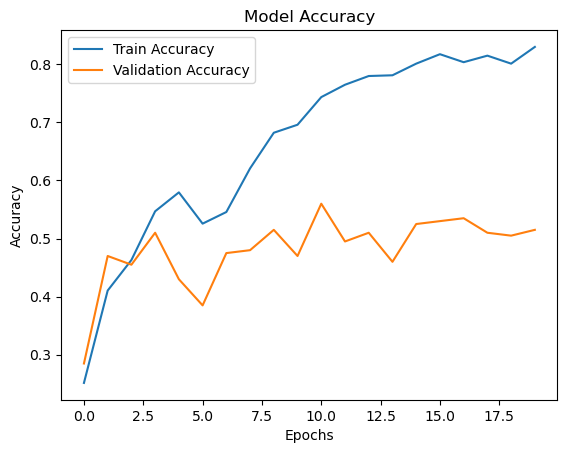

In [35]:

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [36]:

model.save("lstm_audio_classification_model.keras")
print("Model saved as 'lstm_audio_classification_model.keras'")

Model saved as 'lstm_audio_classification_model_1.keras'


In [32]:
from tensorflow.keras.models import load_model


model = load_model("lstm_audio_classification_model.keras")
print("Model loaded successfully!")


Model loaded successfully!


In [37]:

def preprocess_audio(file_path, max_timesteps, n_mfcc=13):
    """
    Preprocess a given audio file to extract MFCC features
    and pad/truncate to the required length.
    """
    y, sr = librosa.load(file_path, sr=22050)  
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc).T  

  
    if mfcc.shape[0] < max_timesteps:
        mfcc = np.pad(mfcc, ((0, max_timesteps - mfcc.shape[0]), (0, 0)), mode="constant")
    else:
        mfcc = mfcc[:max_timesteps, :]

    
    return np.expand_dims(mfcc, axis=0)

In [45]:

new_song_path = r"D:\Edukation\Lectures\WiSe2024\SAA\Dataset\GTZAN\hiphop 1.wav"


max_timesteps = features_padded.shape[1]


preprocessed_song = preprocess_audio(new_song_path, max_timesteps)


print(f"Preprocessed song shape: {preprocessed_song.shape}")


Preprocessed song shape: (1, 1320, 13)


In [46]:

predicted_probabilities = model.predict(preprocessed_song)
predicted_genre_index = np.argmax(predicted_probabilities) 


genre_mapping = {
    0: "blues", 1: "jazz", 2: "country", 3: "disco",
    4: "hiphop", 5: "jazz", 6: "metal", 7: "pop",
    8: "reggae", 9: "rock"
}
predicted_genre = genre_mapping[predicted_genre_index]


print(f"Predicted Genre: {predicted_genre}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Predicted Genre: hiphop


In [1]:
pip install streamlit


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
